# Testing of Temperature REMD

## Setup

In [1]:
using Molly
using ReplicaExchangeMD

In [2]:
using Plots

In [3]:
Threads.nthreads()

8

## System Parameters

In [4]:
n_atoms = 100
atom_mass = 10.0u"u"
atoms = [Atom(mass=atom_mass, σ=0.3u"nm", ϵ=0.2u"kJ * mol^-1") for i in 1:n_atoms];

In [5]:
boundary = CubicBoundary(2.0u"nm", 2.0u"nm", 2.0u"nm")
coords = place_atoms(n_atoms, boundary, 0.3u"nm"); # Random placement without clashing

In [6]:
temp = 100.0u"K"
velocities = [velocity(atom_mass, temp) for i in 1:n_atoms];

In [7]:
pairwise_inters = (LennardJones(),) # Don't forget the trailing comma!

(LennardJones{false, NoCutoff, Int64, Int64, Unitful.FreeUnits{(kJ, nm^-1, mol^-1), 𝐋 𝐌 𝐍^-1 𝐓^-2, nothing}, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}(NoCutoff(), false, true, 1, 1, kJ nm^-1 mol^-1, kJ mol^-1),)

## Test Simulation for normal system

In [8]:
sys = System(
    atoms=atoms,
    pairwise_inters=pairwise_inters,
    coords=coords,
    velocities=velocities,
    boundary=boundary,
    loggers=(
        temp=TemperatureLogger(10),
        coords=CoordinateLogger(10),
    ),
)

System with 100 atoms, boundary CubicBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}(Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}[2.0 nm, 2.0 nm, 2.0 nm])

In [9]:
simulator = VelocityVerlet(
    dt=0.002u"ps",
    coupling=AndersenThermostat(temp, 1.0u"ps"),
);

In [10]:
Molly.simulate!(sys, simulator, 10_000)

System with 100 atoms, boundary CubicBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}(Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}[2.0 nm, 2.0 nm, 2.0 nm])

In [11]:
values(sys.loggers.temp)

1001-element Vector{Quantity{Float64, 𝚯, Unitful.FreeUnits{(K,), 𝚯, nothing}}}:
 93.32878211330527 K
 92.44910037310461 K
 91.10208822822345 K
 89.29486727016376 K
  88.1356716005745 K
 88.16681497836625 K
 86.65919975346473 K
    84.76732818765 K
 84.59774243383643 K
 87.75739327240025 K
                   ⋮
 91.48259209847527 K
 89.17166744872769 K
   89.231962197725 K
  90.3886188222608 K
  92.4798998959021 K
 93.22510352702929 K
 92.84958621194437 K
 93.62018560046856 K
 93.16708580935723 K

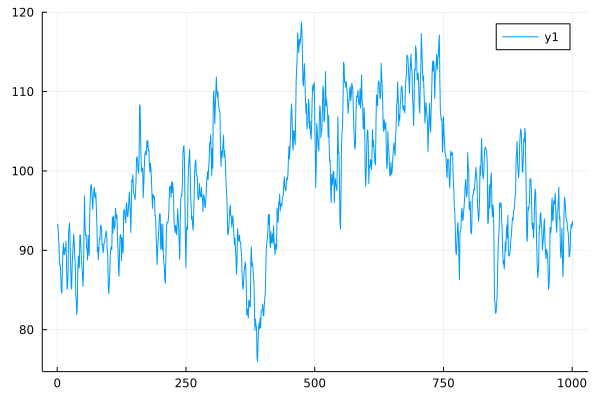

In [12]:
plot(ustrip.(values(sys.loggers.temp)))

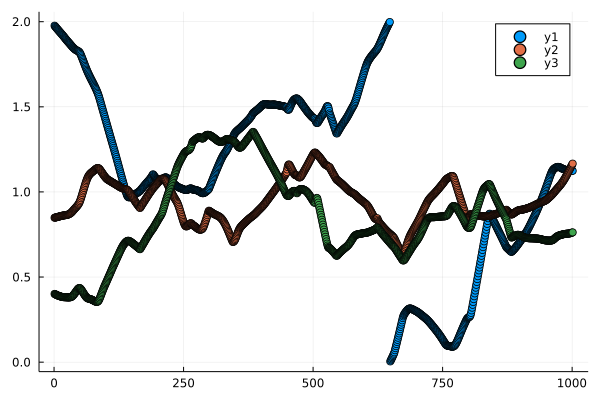

In [13]:
scatter([ustrip(c[50][1]) for c in values(sys.loggers.coords)])
scatter!([ustrip(c[50][2]) for c in values(sys.loggers.coords)])
scatter!([ustrip(c[50][3]) for c in values(sys.loggers.coords)])

# Test simulation for replica system

In [28]:
repsys = ReplicaSystem(
    atoms=atoms,
    coords=coords,
    velocities=velocities,
    n_replicas=4,
    boundary=boundary,
    pairwise_inters=pairwise_inters,
    loggers=Tuple((temp=TemperatureLogger(10), coords=CoordinateLogger(10)) for i in 1:4),
)

temp_vals = [100.0u"K", 200.0u"K", 300.0u"K", 400.0u"K"]
simulator = TemperatureREMD(
    temps=temp_vals,
    simulators=[
        VelocityVerlet(dt=0.005u"ps", coupling=AndersenThermostat(tmp, 1.0u"ps"))
        for tmp in temp_vals],
    exchange_time=4u"ps",
    dt=0.005u"ps"
);

In [29]:
ReplicaExchangeMD.simulate!(repsys, simulator, 4_000);

┌ Info: Total number of cycles: 5 (cycle length: 800, remaining steps: 0)
└ @ ReplicaExchangeMD d:\Projects\OpenSource\ReplicaExchangeMD.jl\src\simulators.jl:42


┌ Info: Number of exchanges: 4
└ @ ReplicaExchangeMD d:\Projects\OpenSource\ReplicaExchangeMD.jl\src\simulators.jl:79


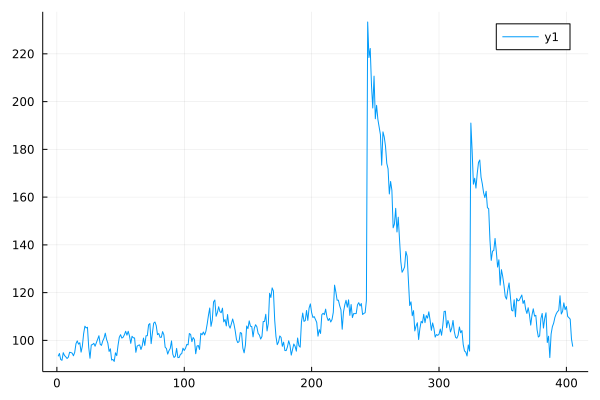

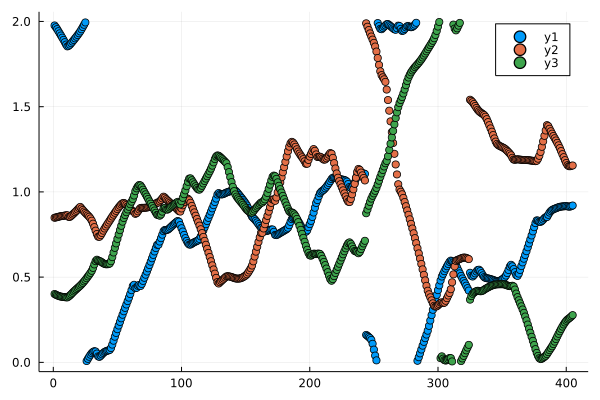

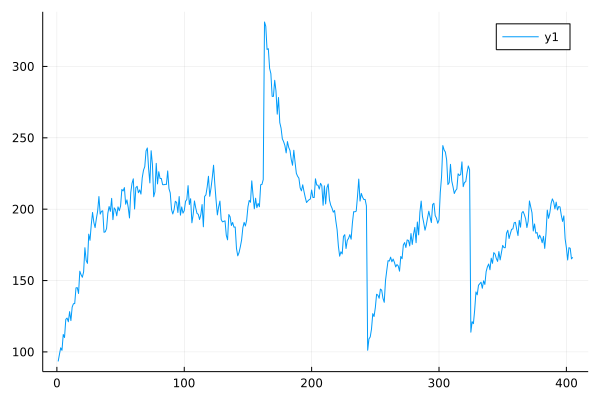

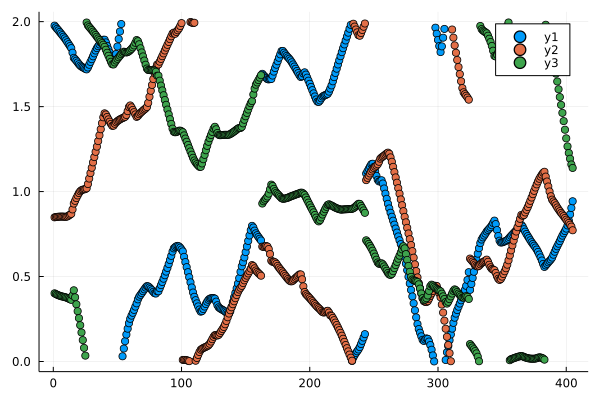

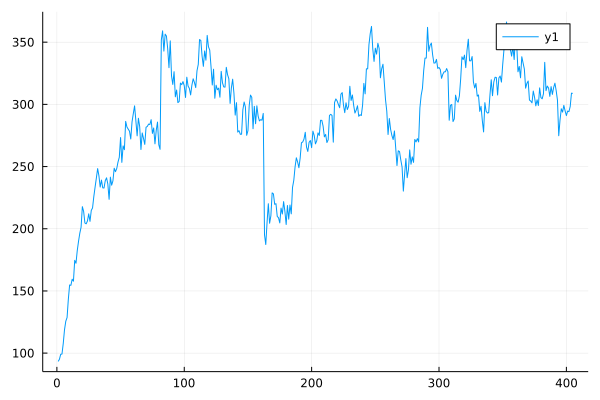

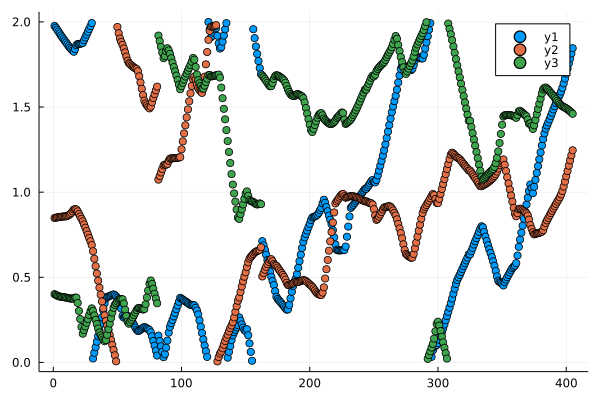

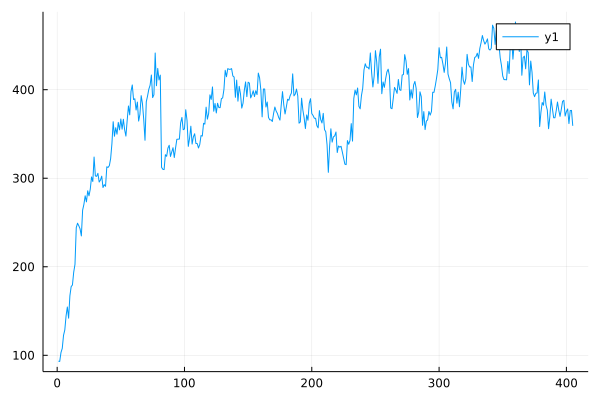

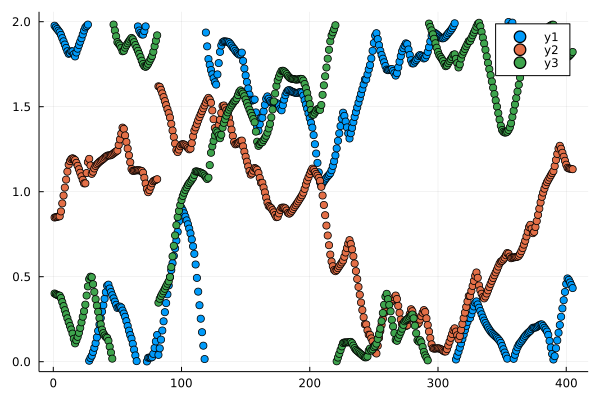

In [30]:
for repidx=1:4
s = plot(ustrip.(values(repsys.loggers[repidx].temp)))
display(s)
s = scatter([ustrip(c[50][1]) for c in values(repsys.loggers[repidx].coords)])
scatter!([ustrip(c[50][2]) for c in values(repsys.loggers[repidx].coords)])
scatter!([ustrip(c[50][3]) for c in values(repsys.loggers[repidx].coords)])
display(s)
end

In [31]:
s = scatter([ustrip(c[7][1]) for c in values(repsys.loggers[1].coords)], label=temp_vals[1])
for repidx=2:4
    scatter!([ustrip(c[7][1]) for c in values(repsys.loggers[repidx].coords)], label=temp_vals[repidx])
end
savefig(s, "plots/x_coordiantes_of_atom_7_in_each_replica.png")

In [32]:
s = plot(ustrip.(values(repsys.loggers[1].temp)), label=temp_vals[1])
for repidx=2:4
    plot!(ustrip.(values(repsys.loggers[repidx].temp)), label=temp_vals[repidx])
end
savefig(s, "plots/temperature_of_each_replica.png")

In [33]:
using Statistics

for repidx=1:4
    mean(ustrip.(values(repsys.loggers[repidx].temp))) |> println
end

113.28684849733445
193.99308465096266
286.07942783644165
374.64681790327586
